In [ ]:
# Ejercicio 2, Cápitulo 2

# Importación de bibliotecas necesarias para el modelo y visualización

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#----------------------------------------------------------------------#
# Definición de funciones: solución exacta y término fuente
#----------------------------------------------------------------------#

# Función que representa la solución exacta del problema
def u_exact(x):
    return torch.sin(torch.pi*x)

# Función que define el término fuente de la EDP
def rhs(x):
    return -(torch.pi)**2*(torch.sin(torch.pi*x))


In [ ]:
#----------------------------------------------------------------------#
# Definición del modelo de red neuronal y su evaluación
#----------------------------------------------------------------------#

# Se construye un modelo secuencial de Keras con tres capas ocultas de
# 50 neuronas y activación tanh, seguido de una capa de salida con una
# sola neurona para producir una salida escalar.

# Definición del modelo (equivalente a tf.keras.Sequential)

# Número de Neuronas x capa
n = 10

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden1 = nn.Linear(1, n)
        self.hidden2 = nn.Linear(n, n)
        self.hidden3 = nn.Linear(n, n)
        self.hidden4 = nn.Linear(n, n)
        self.hidden5 = nn.Linear(n, n)
        self.out = nn.Linear(n, 1)

    def forward(self, x):
        x = torch.tanh(self.hidden1(x))
        x = torch.tanh(self.hidden2(x))
        x = torch.tanh(self.hidden3(x))
        # x = torch.tanh(self.hidden4(x))
        # x = torch.tanh(self.hidden5(x))
        return self.out(x)

# Evaluación del modelo (paso hacia adelante)
def call_model(model, x):
    return model(x)

In [ ]:
#----------------------------------------------------------------------#
# Definición de la ecuación diferencial mediante autogradiente
# y de la función de pérdida
#----------------------------------------------------------------------#

# Se usa tf.GradientTape para calcular derivadas automáticas.
# La función `pde` define la ecuación diferencial y la función `loss`
# calcula el error total combinando el residuo de la PDE en el dominio interior
# y el error en las condiciones de frontera.

# PDE con derivadas automáticas en PyTorch
def pde(x, model):
    x.requires_grad_(True)
    y_pred = call_model(model, x)

    # Primera derivada
    y_x = torch.autograd.grad(
        y_pred, x,
        grad_outputs=torch.ones_like(y_pred),
        create_graph=True
    )[0]

    # Segunda derivada
    y_xx = torch.autograd.grad(
        y_x, x,
        grad_outputs=torch.ones_like(y_x),
        create_graph=True
    )[0]

    return y_xx - rhs(x)

# Función de pérdida total (dominio + frontera)
def loss_fn(model, x, x_bc, y_bc):
    res = pde(x, model)
    loss_pde = torch.mean(res ** 2)

    y_bc_pred = call_model(model, x_bc)
    loss_bc = torch.mean((y_bc - y_bc_pred) ** 2)

    return loss_pde + loss_bc

In [ ]:
#----------------------------------------------------------------------#
# Definición del paso de entrenamiento
#----------------------------------------------------------------------#

# En este bloque se define cómo se actualizan los pesos del modelo en
# una iteración de entrenamiento. Se calcula el valor de la función de
# pérdida, se obtienen sus gradientes respecto a los parámetros entrenables
# del modelo y se actualizan usando un optimizador de TensorFlow.

# Ejecuta un paso de entrenamiento para el modelo
def train(model, x, x_bc, y_bc, epochs=3000, lr=1e-3, decay_rate=0.9, decay_steps=1000):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay_rate)

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss_value = loss_fn(model, x, x_bc, y_bc)
        loss_value.backward()
        optimizer.step()

        # Actualiza la tasa de aprendizaje cada cierto número de pasos
        if (epoch + 1) % decay_steps == 0:
            scheduler.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss_value.item():.6e}")

    print(f"Epoch {epochs}: Final loss = {loss_value.item():.6e}")                              # Devuelve el valor actual de la pérdida


In [ ]:
#----------------------------------------------------------------------#
# Configuración y entrenamiento del problema
#----------------------------------------------------------------------#

# Se define el dominio del problema, se generan los datos de
# entrenamiento (interior y frontera), se construye el modelo,
# se configura el optimizador con una tasa de aprendizaje decreciente,
# y se entrena la red neuronal durante un número fijo de épocas.

# Intervalo
xI = -1
xF = 1

# Puntos del dominio interior
x_train = np.linspace(xI, xF, 20 + 2).reshape(-1, 1)
x_train = torch.tensor(x_train, dtype=torch.float32)

# Condiciones de frontera
uI = u_exact(torch.tensor([[xI]], dtype=torch.float32))
uF = u_exact(torch.tensor([[xF]], dtype=torch.float32))

x_bc = torch.tensor([[xI], [xF]], dtype=torch.float32)
y_bc = torch.cat([uI, uF], dim=0)

# Crear y entrenar modelo
model = PINN()
train(model, x_train, x_bc, y_bc)

Epoch 0: Loss = 4.710713e+01
Epoch 100: Loss = 2.889069e+01
Epoch 200: Loss = 1.219516e+01
Epoch 300: Loss = 3.840239e+00
Epoch 400: Loss = 4.551780e-01
Epoch 500: Loss = 1.221456e-01
Epoch 600: Loss = 6.189163e-02
Epoch 700: Loss = 4.270438e-02
Epoch 800: Loss = 3.194853e-02
Epoch 900: Loss = 2.435204e-02
Epoch 1000: Loss = 1.868315e-02
Epoch 1100: Loss = 1.475287e-02
Epoch 1200: Loss = 1.164494e-02
Epoch 1300: Loss = 9.177852e-03
Epoch 1400: Loss = 7.214234e-03
Epoch 1500: Loss = 5.649548e-03
Epoch 1600: Loss = 4.403650e-03
Epoch 1700: Loss = 3.415325e-03
Epoch 1800: Loss = 2.636657e-03
Epoch 1900: Loss = 2.029908e-03
Epoch 2000: Loss = 1.564022e-03
Epoch 2100: Loss = 1.243120e-03
Epoch 2200: Loss = 9.973379e-04
Epoch 2300: Loss = 8.126079e-04
Epoch 2400: Loss = 6.760856e-04
Epoch 2500: Loss = 5.764301e-04
Epoch 2600: Loss = 5.040768e-04
Epoch 2700: Loss = 4.514227e-04
Epoch 2800: Loss = 4.126471e-04
Epoch 2900: Loss = 3.836191e-04
Epoch 3000: Final loss = 3.616363e-04



--> L2: 0.004264



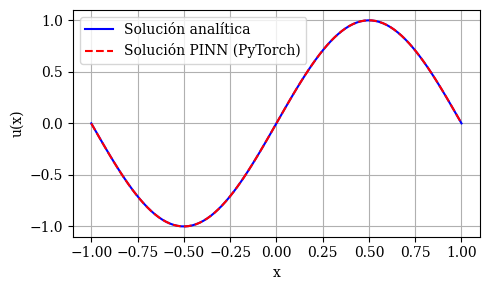

In [ ]:
#----------------------------------------------------------------------#
# Evaluación del modelo y visualización de resultados
#----------------------------------------------------------------------#

# Se generan puntos de prueba, se calcula la solución predicha por la
# red neuronal y se compara con la solución exacta. Finalmente, se grafican
# ambas soluciones para visualizar la precisión del modelo entrenado.

# Predicción de la solución en puntos de prueba
x_test = np.linspace(xI, xF, 100).reshape(-1, 1)
x_test_torch = torch.tensor(x_test, dtype=torch.float32)

y_pred = call_model(model, x_test_torch).detach().numpy()

# Solución analítica (exacta) para comparación
y_true = u_exact(torch.tensor(x_test, dtype=torch.float32)).detach().numpy()

# Error absoluto promedio
L2 = np.sqrt(np.sum((y_true - y_pred)**2))
print(f"\n--> L2: {L2:.6f}\n")

# Configuración del estilo del gráfico
plt.close('all')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'
plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 100


fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# Gráfica de resultados
# ax[0].figure(figsize=(5, 3))
# ax.set_title(f'Cantidad de Neuronas x capa : {n}, 3 Capas')
ax.plot(x_test, y_true, 'b-', label='Solución analítica')
ax.plot(x_test, y_pred, 'r--', label='Solución PINN (PyTorch)')
ax.set_xlabel('x')
ax.set_ylabel('u(x)')
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.savefig(f'Neu{n}_3Capas_3000.png')                                        # Ajusta el diseño de la figura
plt.show()